# Polygon drill

In [1]:
%matplotlib inline

In [2]:
import fiona
import rasterio.features
#import pandas
#pandas.set_option('display.max_colwidth', 200)
#pandas.set_option('display.max_rows', 5) # limit of 5 rows to show

In [3]:
import datacube
from datacube.utils import geometry
from datacube.storage.masking import mask_invalid_data

In [4]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)



In [10]:
shape_file = '/home/554/lm4502/DEA_extract_CRV.shp'
with fiona.open(shape_file) as shapes:
    crs = geometry.CRS(shapes.crs_wkt)
    first_geometry = next(iter(shapes))['geometry']
    geom = geometry.Geometry(first_geometry, crs=crs)

query = {
    'time': ('1990-01-01', '1991-01-01'),
    'geopolygon': geom
}
    
dc = datacube.Datacube(app='poly-drill-recipe')
data = dc.load(product='ls8_fc_albers',
    x=(147.35, 147.6), y=(-42.7, -42.95),
    time=('2017-01-01', '2018-01-01'))
data = mask_invalid_data(data)
    
mask = geometry_mask([geom], data.geobox, invert=True)
data = data.where(mask)

In [11]:
shape_file

'/home/554/lm4502/DEA_extract_CRV.shp'

In [12]:
data

<xarray.Dataset>
Dimensions:  (time: 39, x: 968, y: 1173)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T23:52:52.500000 ...
  * y        (y) float64 -4.745e+06 -4.745e+06 -4.745e+06 -4.745e+06 ...
  * x        (x) float64 1.289e+06 1.289e+06 1.29e+06 1.29e+06 1.29e+06 ...
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    UE       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


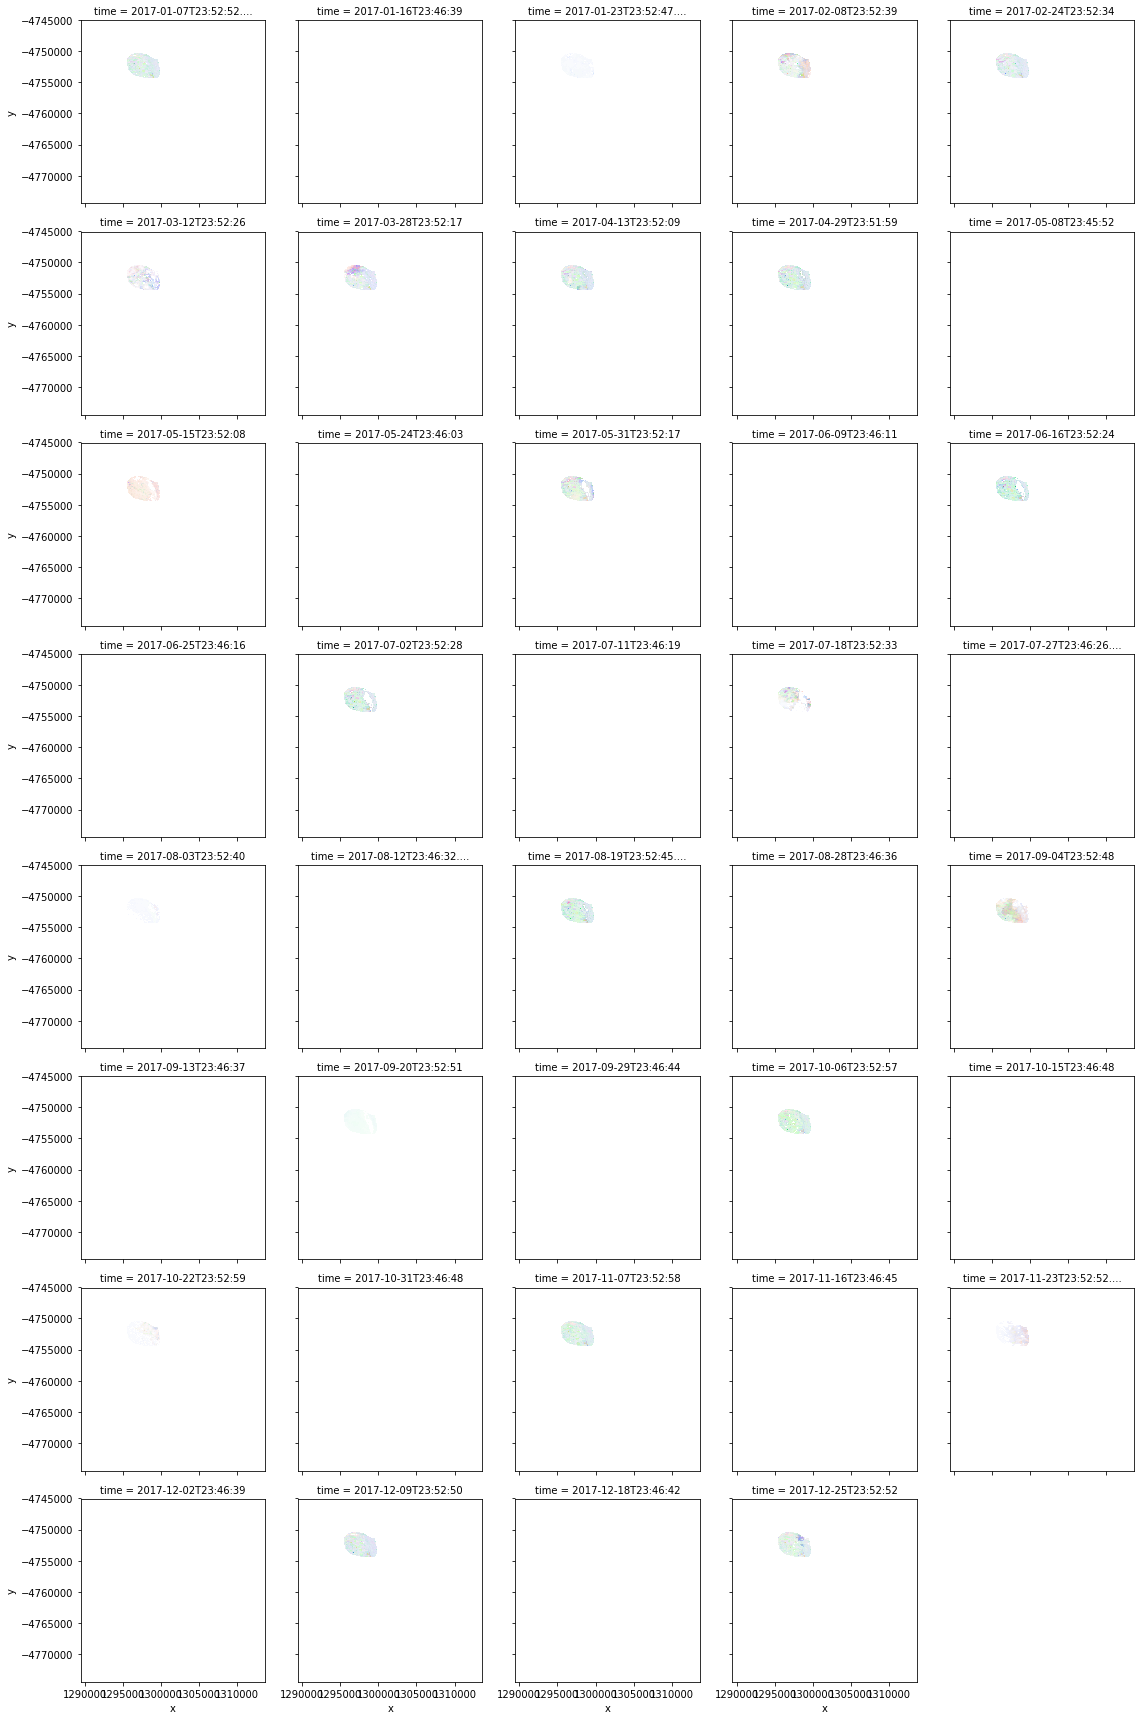

In [13]:
fake_saturation = 80
rgb = data.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
rgb /= fake_saturation  # scale to [0, 1] range for imshow

rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
                col='time', col_wrap=5, add_colorbar=False)

In [15]:
datacube.storage.storage.write_dataset_to_netcdf(data, '/home/554/lm4502/fc_test_polyextract')